In [1]:
import pandas as pd 
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
# from feature-engine
from feature_engine import missing_data_imputers as mdi
import scipy.stats as stats
from feature_engine import variable_transformers as vt
import matplotlib.pyplot as plt
from feature_engine.discretisers import EqualWidthDiscretiser
from feature_engine.discretisers import DecisionTreeDiscretiser
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
# the scaler - for standardisation
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

In [2]:
# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb#  for this i have to install package  "  !pip install lightgbm "
import xgboost as xgb
# Data preprocessing :
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, scale, LabelEncoder, OneHotEncoder
# Modeling helper functions
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_score,recall_score,f1_score

In [3]:
# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
year_1=pd.read_csv(r"C:\Users\sak\Documents\current_hackathon\bank_ruptcy\Bankruptcy dataset\1year.csv")

In [6]:
k1=year_1.columns.tolist()

In [7]:
#replacing each ? to NAN
for i in k1:
    year_1[i] = year_1[i].replace('?' , np.nan)

In [8]:
#converting object data into numericals(float64)
year_1=year_1.apply(lambda col:pd.to_numeric(col,errors='coerce'))

In [9]:
# Let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    year_1.drop(labels='class', axis=1),  # predictors
    year_1['class'],  # target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((4908, 64), (2104, 64))

In [10]:
# replacing null with mean imputer 
mean_imputer= mdi.MeanMedianImputer(imputation_method='mean', variables = year_1.drop(labels='class',axis=1).columns.tolist())

In [11]:
mean_imputer.fit(X_train)

MeanMedianImputer(imputation_method='mean',
                  variables=['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5',
                             'Attr6', 'Attr7', 'Attr8', 'Attr9', 'Attr10',
                             'Attr11', 'Attr12', 'Attr13', 'Attr14', 'Attr15',
                             'Attr16', 'Attr17', 'Attr18', 'Attr19', 'Attr20',
                             'Attr21', 'Attr22', 'Attr23', 'Attr24', 'Attr25',
                             'Attr26', 'Attr27', 'Attr28', 'Attr29', 'Attr30', ...])

In [12]:
# let's transform the data with the pipeline
X_train_imp= mean_imputer.transform(X_train)
X_test_imp= mean_imputer.transform(X_test)

In [13]:
X_train_no_miss=X_train_imp.copy()
X_test_no_miss=X_test_imp.copy()
y_train_no_miss=y_train.copy()
y_test_no_miss=y_test.copy()

In [14]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

In [15]:
X_train=X_train_no_miss.copy()
X_test=X_test_no_miss.copy()
y_train=y_train_no_miss.copy()
y_test=y_test_no_miss.copy()

In [16]:
# I keep a copy of the dataset with all the variables
# to measure the performance of machine learning models
# at the end of the notebook
X_train_original = X_train.copy()
X_test_original = X_test.copy()

### Remove constant features

In [17]:
#before removing constatnt features
X_train.shape,X_test.shape

((4908, 64), (2104, 64))

In [18]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
 
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((4908, 64), (2104, 64))

### Remove quasi-constant features

In [19]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.1)  # 0.1 indicates 99% of observations approximately
 
sel.fit(X_train)  # fit finds the features with low variance
 
sum(sel.get_support()) # how many not quasi-constant?

64

In [20]:
features_to_keep = X_train.columns[sel.get_support()]

In [21]:
 #we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)
 
X_train.shape, X_test.shape

((4908, 64), (2104, 64))

In [22]:
#sklearn transformations lead to numpy arrays
#here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly
 
X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep
 
X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features


In [23]:
# check for duplicated features in the training set
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)
 
    col_1 = X_train.columns[i]
 
    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)#no of duplicate features?

0
10
20
30
40
50
60


3

In [24]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((4908, 62), (2104, 62))

In [25]:
# I keep a copy of the dataset except constant and duplicated variables
# to measure the performance of machine learning models
# at the end of the notebook
 
X_train_basic_filter = X_train.copy()
X_test_basic_filter = X_test.copy()

## Remove correlated features

In [26]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr
 
corr_features = correlation(X_train, 0.85)
print('correlated features: ', len(set(corr_features)) )

correlated features:  35


In [27]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)
 
X_train.shape, X_test.shape

((4908, 27), (2104, 27))

In [28]:
# keep a copy of the dataset at  this stage
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()

## Remove features using univariate ROC-AUC


In [29]:
# find important features using univariate roc-auc
 
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
 
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

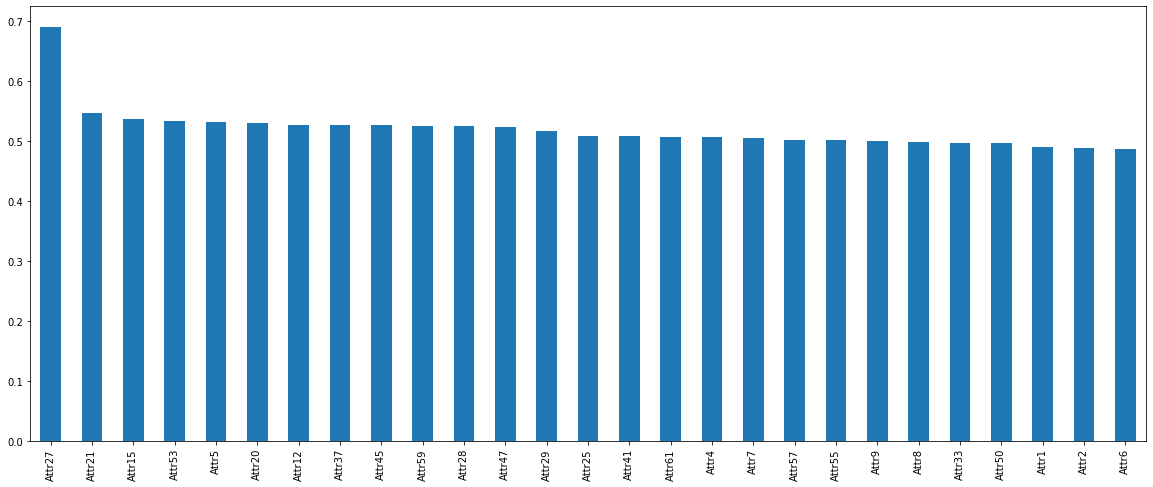

In [30]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [31]:
# by removing features with univariate roc_auc == 0.5
# we remove another 30 features
 
selected_feat = roc_values[roc_values>0.5]
len(selected_feat), X_train.shape[1]

(21, 27)

### select feature based on random forest feature importance 

In [32]:
# select features using the impotance derived from
# random forests
#sel_ = SelectFromModel(RandomForestClassifier(n_estimators=200))
#sel_.fit(X_train, y_train)
 
# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
#X_train_rf = pd.DataFrame(sel_.transform(X_train))
#X_test_rf = pd.DataFrame(sel_.transform(X_test))
 
# add the columns name
#X_train_rf.columns = X_train.columns[(sel_.get_support())]
#X_test_rf.columns = X_train.columns[(sel_.get_support())]

In [33]:
#X_train_rf.columns

###### using random forest feature importance i got these set of features 

Index(['Attr6', 'Attr9', 'Attr27', 'Attr29', 'Attr41'], dtype='object')

###  feature selection using xgboosting feature importance 

In [34]:
# select features using the impotance derived from
# xgb0sting algo 
#sel_ = SelectFromModel(xgb.XGBClassifier(n_estimators=200))
#sel_.fit(X_train, y_train)
 
# remove features with zero coefficient from dataset
# and parse again as dataframe (output of sklearn is
# numpy array)
#X_train_rf = pd.DataFrame(sel_.transform(X_train))
#X_test_rf = pd.DataFrame(sel_.transform(X_test))
 
# add the columns name
#X_train_rf.columns = X_train.columns[(sel_.get_support())]
#X_test_rf.columns = X_train.columns[(sel_.get_support())]

In [35]:
#X_train_rf.columns

###### using xgboosting feature importance i got these set of features 

Index(['Attr2', 'Attr6', 'Attr7', 'Attr9', 'Attr12', 'Attr15', 'Attr21',
       'Attr25', 'Attr27', 'Attr29', 'Attr41', 'Attr45'],
      dtype='object')

###### but i have analysed explicitly set of features which are giving me best confusion matrix result are 

[['Attr5', 'Attr11', 'Attr21', 'Attr22', 'Attr24', 'Attr27', 'Attr33',
       'Attr40', 'Attr46', 'Attr55']]                                         


###### above feature set i have gone through some feature engineering steps 
###### missing imputation------>gaussian transformation ----->decision tree descritisation------>scaling --->feature selection 
[['Attr5', 'Attr11', 'Attr21', 'Attr22', 'Attr24', 'Attr27', 'Attr33', 'Attr40', 'Attr46', 'Attr55']] i got these features 

###### but important analysis i found that feature set using these above feature engineering steps giving best result on original data aftter imputation only 

In [36]:
data=pd.read_csv(r"C:\Users\sak\Documents\current_hackathon\bank_ruptcy\Bankruptcy dataset\1year.csv")

In [37]:
year_1=data[['Attr5', 'Attr11', 'Attr21', 'Attr22', 'Attr24', 'Attr27', 'Attr33',
       'Attr40', 'Attr46', 'Attr55','class']] 

In [38]:
k1=year_1.columns.tolist()

In [39]:
#replacing each ? to NAN
for i in k1:
    year_1[i] = year_1[i].replace('?' , np.nan)

C:\Users\sak\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
#converting object data into numericals(float64)
year_1=year_1.apply(lambda col:pd.to_numeric(col,errors='coerce'))

In [41]:
# Let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    year_1.drop(labels='class', axis=1),  # predictors
    year_1['class'],  # target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((4908, 10), (2104, 10))

In [42]:
# replacing null with mean imputer 
mean_imputer= mdi.MeanMedianImputer(imputation_method='mean', variables = year_1.drop(labels='class',axis=1).columns.tolist())

In [43]:
mean_imputer.fit(X_train)

MeanMedianImputer(imputation_method='mean',
                  variables=['Attr5', 'Attr11', 'Attr21', 'Attr22', 'Attr24',
                             'Attr27', 'Attr33', 'Attr40', 'Attr46', 'Attr55'])

In [44]:
# let's transform the data 
X_train_imp= mean_imputer.transform(X_train)
X_test_imp= mean_imputer.transform(X_test)

In [45]:
X_train_no_miss=X_train_imp.copy()
X_test_no_miss=X_test_imp.copy()
y_train_no_miss=y_train.copy()
y_test_no_miss=y_test.copy()

In [46]:
#standardisation: with the StandardScaler from sklearn

# set up the scaler
scaler = StandardScaler()
# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train_no_miss)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [47]:
X_train_no_miss_scaled = scaler.transform(X_train_no_miss)
X_test_no_miss_scaled = scaler.transform(X_test_no_miss)

##### over sampling using smote 

In [48]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train_no_miss_scaled, y_train_no_miss.ravel())

AttributeError: 'SMOTE' object has no attribute '_validate_data'

## ------------------------------------------model analysis ----------------------------------------------------

In [ ]:
X_tr=X_train_res.copy()
X_ts=X_test_no_miss_scaled.copy()
y_tr=y_train_res.copy()
y_ts=y_test_no_miss.copy()

In [ ]:
names = ["Logistic Regression", "Nearest Neighbors", "Naive Bayes", "Linear SVM", "RBF SVM",
          "Decision Tree", "Random Forest", "AdaBoost", "Gradient Boosting", 
         "LDA", "QDA", "Neural Net", "LightGBM", "XGBoost" ]

In [ ]:
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(7),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(kernel = "rbf", gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier(alpha=1, max_iter=1000),
    lgb.LGBMClassifier(),    
    xgb.XGBClassifier()
   ]

In [ ]:
accuracy_scores = []
# iterate over classifiers and predict accuracy
for name, clf in zip(names, classifiers):
    clf.fit(X_tr, y_tr)
    score = clf.score(X_ts, y_ts)
    score = round(score, 4)
    accuracy_scores.append(score)
    print(name ,' : ' , score )


In [ ]:
knn_clf = KNeighborsClassifier(11)

knn_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = knn_clf.predict(X_tr)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = knn_clf.predict(X_ts)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


In [ ]:
svl_clf = SVC(kernel="linear", C=0.025)

svl_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = svl_clf.predict(X_tr)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = svl_clf.predict(X_ts)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


In [ ]:
xgb_clf = xgb.XGBClassifier()

xgb_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = xgb_clf.predict(X_tr)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = xgb_clf.predict(X_ts)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


In [ ]:
lgb_clf = lgb.LGBMClassifier()

lgb_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = lgb_clf.predict(X_tr)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = lgb_clf.predict(X_ts)
# print the accuracy
print('Gradient boosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


### i  m performing oversampling on original data without scaling becoz  w/o scaling is giving better result  

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train_no_miss, y_train_no_miss.ravel())

In [ ]:
X_tr=X_train_res.copy()
X_ts=X_test_no_miss.copy()
y_tr=y_train_res.copy()
y_ts=y_test_no_miss.copy()

In [ ]:
xgb_clf = xgb.XGBClassifier()

xgb_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = xgb_clf.predict(X_tr)
# print the accuracy
print('xgboosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = xgb_clf.predict(X_ts)
# print the accuracy
print('xgBoosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


In [ ]:
lgb_clf = lgb.LGBMClassifier()

lgb_clf.fit(X_tr, y_tr)
#predict train set 
print('train set')
y1_pred = lgb_clf.predict(X_tr)
# print the accuracy
print('light gradient boosting Classifier model accuracy score for train set : {0:0.4f}'. format(accuracy_score(y_tr, y1_pred)))

#-------------------------------------------------------------------------------------------------------------------------------

#predict test set
print('test set')
y2_pred = lgb_clf.predict(X_ts)
# print the accuracy
print('light gradiant boosting Classifier model accuracy score for test set : {0:0.4f}\n\n'. format(accuracy_score(y_ts, y2_pred)))

#-------------------------------------------------confusion matrix-----------------------------------------------------------

# print confusion-matrix

cm = confusion_matrix(y_ts, y2_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP){type 1 error} = ', cm[0,1])

print('\nFalse Negatives(FN){type 2 error} = ', cm[1,0])
print('\n\n')

#-------------------------------visualization of confusion matrix -----------------------------------------------------------

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:0', 'Actual Negative:1'], 
                                 index=['Predict Positive:0', 'Predict Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#----------------------------------classification report ----------------------------------------------------------------------
print('classification report')
print(classification_report(y_ts, y2_pred))
print('\n\n')


##### conclusion:- till now best result i found with XGBoosting algorithm and i will deploye first year data model based on the XGboosting algo only 